In [1]:
import numpy as np
import scipy as sp
import scipy.optimize
from dataclasses import dataclass
from matplotlib import pyplot as plt

def dot(a, b):
    return np.multiply(a, b).sum(axis=-2)

def make_vec3(x, y, z):
    return np.array((x, y, z)).reshape(3, 1)

@dataclass
class SG:
    axis: np.ndarray
    amplitude: np.ndarray
    sharpness: np.ndarray

    def eval(self, v):
        r = self.amplitude * np.exp(self.sharpness * (dot(v, self.axis) - 1))
        s = r.sum(axis=0)
        return s

def polar_to_r3(phi, axis=0):
    phi = phi if len(np.shape(phi)) > 0 else np.reshape(phi, 1)
    p = np.stack((np.cos(phi), np.zeros(np.shape(phi)), np.sin(phi)), axis=axis)
    return p

def newton(f, df, x0, n):
    xp = x0
    x = x0
    for i in range(n):
        x = xp - f(xp) / df(xp)
        xp = x
    return x

def F_schlick(f0, NoL):
    return f0 + (1 - f0) * (1 - NoL) ** 5

def G_smith(alpha, NoV, NoL):
    alpha2 = alpha ** 2;
    NoV2 = NoV ** 2
    NoL2 = NoL ** 2
    A_V = np.sqrt(1 + alpha2 * (1 - NoV2) / NoV2)
    A_L = np.sqrt(1 + alpha2 * (1 - NoL2) / NoL2)
    return 2 / (A_V + A_L)

def D_ggx(alpha, NoH):
    alpha2 = alpha ** 2
    return alpha2 / (np.pi * (1 + NoH ** 2 * (alpha2 - 1)) ** 2)

def BRDF(f0, alpha, N, V, L, mul_NoL=False):
    H = L + V
    H = H / np.linalg.norm(H, axis=0)
    HoV = dot(V, H)
    NoV = dot(N, V)
    NoL = dot(N, L)
    NoH = dot(N, H)
    F = F_schlick(f0, HoV)
    G = G_smith(alpha, NoV, NoL)
    D = D_ggx(alpha, NoH)
    if mul_NoL:
        return np.where(NoL > 0, F * G * D / (4 * NoV), 0)
    return np.where(NoL > 0, F * G * D / (4 * NoV * NoL), 0)

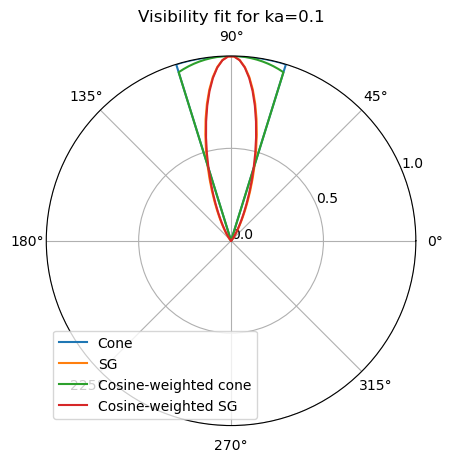

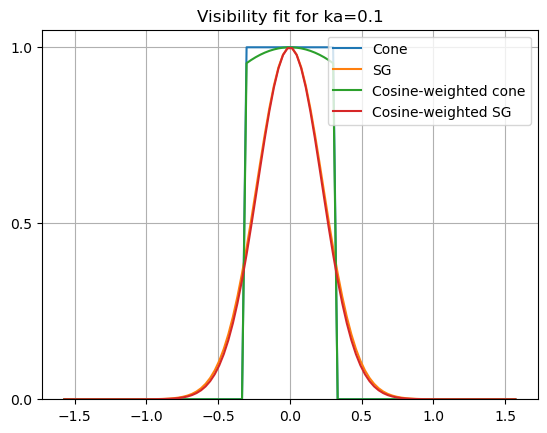

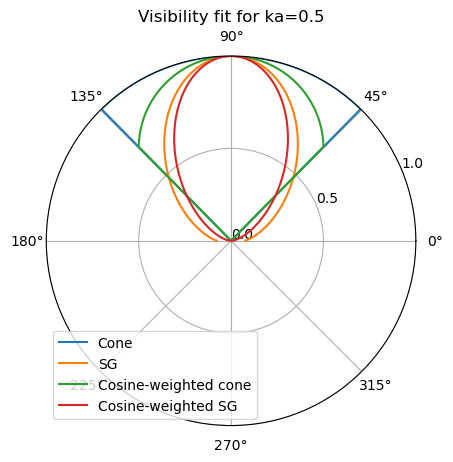

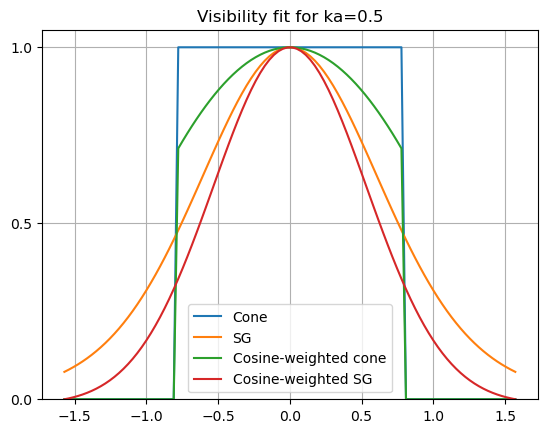

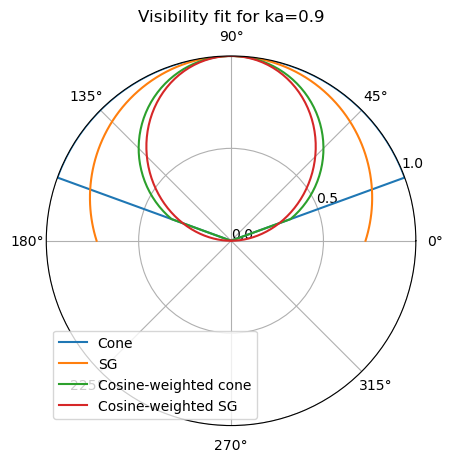

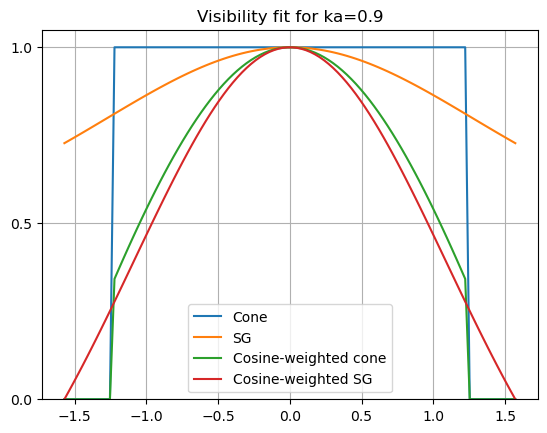

In [2]:
# Fit visibility SG

@dataclass
class Cone:
    axis: np.ndarray
    aperture: np.ndarray

    def eval(self, v):
        return np.where(dot(v, self.axis) > np.cos(self.aperture), 1.0, 0.0)

def ka_from_lambda(l):
    return 2.0 * (l + np.exp(-l) - 1.0) / (l * l)

def ka_from_lambda_diff(l):
    return -2.0 * (l - 2.0 + np.exp(-l) * (l + 2.0)) / (l * l * l)

def l0_from_ka(ka):
    return 2.0 / (ka + 0.01) * (1.0 - ka) + 3.0 * (1.0 - ka) * ka

for ka in (0.1, 0.5, 0.9):
    N = make_vec3(0, 0, 1)
    
    l0 = l0_from_ka(ka)
    l1 = newton(lambda l: ka_from_lambda(l) - ka, ka_from_lambda_diff, l0, 1)
    sg = SG(np.reshape(N, (1, 3, 1)), np.reshape(1, (1, 1)), np.reshape(l1, (1, 1)))

    aperture = np.acos(np.sqrt(1.0 - ka))
    c = Cone(N, aperture)

    phi = np.linspace(0, np.pi, num=100)
    axis = polar_to_r3(phi)

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

    plt.title(f"Visibility fit for ka={ka}")
    ax.plot(phi, c.eval(axis), label=f"Cone")
    ax.plot(phi, sg.eval(axis), label=f"SG")
    ax.plot(phi, c.eval(axis) * np.sin(phi), label = f"Cosine-weighted cone")
    ax.plot(phi, sg.eval(axis) * np.sin(phi), label = f"Cosine-weighted SG")
    ax.set_rmax(1)
    ax.set_rticks([0.0, 0.5, 1])
    ax.grid(True)
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    plt.title(f"Visibility fit for ka={ka}")
    ax.plot(phi - np.pi / 2.0, c.eval(axis), label=f"Cone")
    ax.plot(phi - np.pi / 2.0, sg.eval(axis), label=f"SG")
    ax.plot(phi - np.pi / 2.0, c.eval(axis) * np.sin(phi), label = f"Cosine-weighted cone")
    ax.plot(phi - np.pi / 2.0, sg.eval(axis) * np.sin(phi), label = f"Cosine-weighted SG")
    ax.set_ylim(1)
    ax.set_yticks([0.0, 0.5, 1])
    ax.grid(True)
    ax.legend()
    plt.show()

[[ 3111.56012774 19801.86423966]]
[[ 1555.72042619 19801.559915  ]
 [ 1555.72042619 19801.559915  ]]


/tmp/ipykernel_117203/4108750627.py:20: RuntimeWarning: overflow encountered in exp
  r = self.amplitude * np.exp(self.sharpness * (dot(v, self.axis) - 1))
/tmp/ipykernel_117203/2890319710.py:26: OptimizeWarning: Covariance of the parameters could not be estimated
  d_sg, _ = sp.optimize.curve_fit(eval_ggx_sg, phi, d, p0=p0)


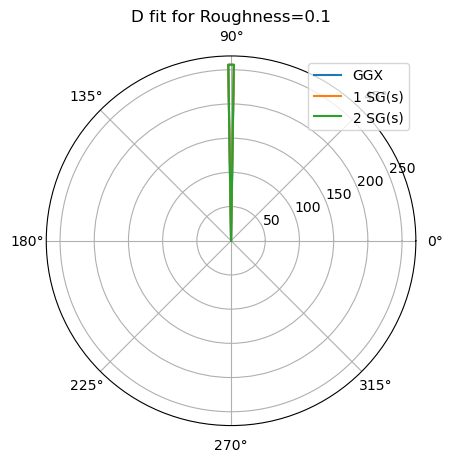

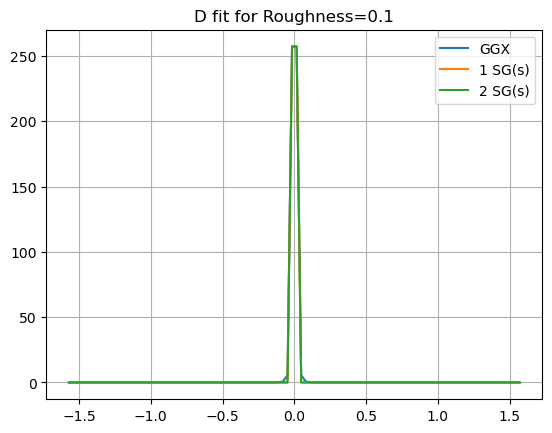

[[ 4.82089684 39.43473086]]
[[ 3.75479695 67.28742286]
 [ 1.29034963 12.35920632]]


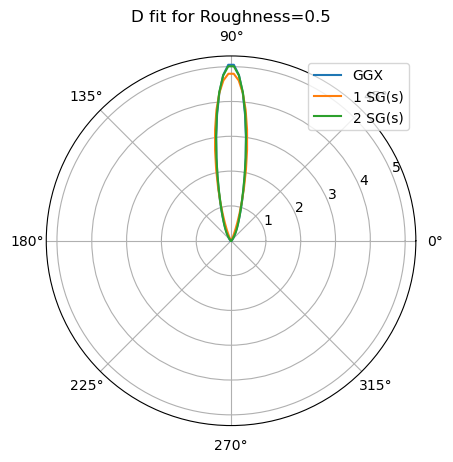

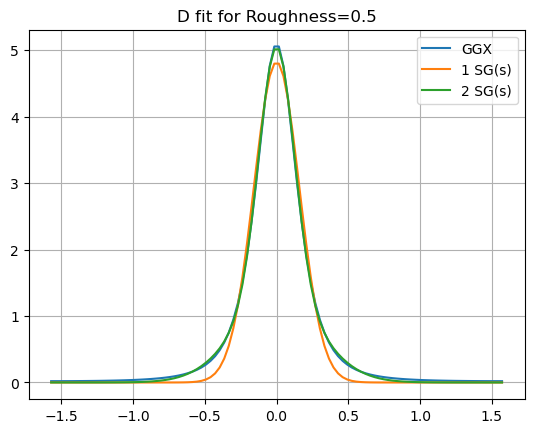

[[0.45400077 1.05688476]]
[[ 0.29507247  3.28202868]
 [ 0.18906351 -0.03464689]]


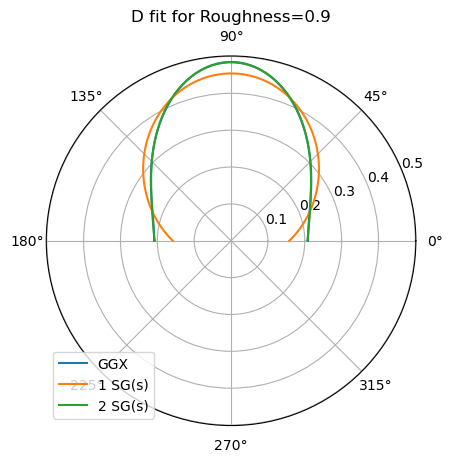

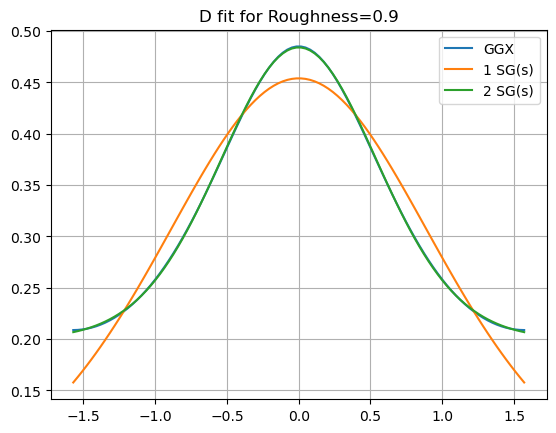

In [3]:
# Fit normal distribution SG

for roughness in (0.1, 0.5, 0.9):
    N = make_vec3(0, 0, 1)
    
    alpha = roughness ** 2
    alpha2 = alpha ** 2

    phi = np.linspace(0, np.pi, num=100)
    H = polar_to_r3(phi)
    d = D_ggx(alpha, dot(N, H))

    def eval_ggx_sg(phi, *args):
        args = np.array(args).reshape(-1, 2, 1)
        amp = args[:, 0]
        sh = args[:, 1]
        axis = np.full(amp.shape, np.pi / 2)
        return SG(polar_to_r3(axis, axis=1), amp, sh).eval(polar_to_r3(phi))

    d_sgs = []

    for i in range(2):
        k = i + 1
        try:
            p0 = np.tile((1 / (np.pi * alpha2 * k), 2 / alpha2), k)
            d_sg, _ = sp.optimize.curve_fit(eval_ggx_sg, phi, d, p0=p0)
            print(d_sg.reshape(-1, 2))
            d_sgs.append(d_sg)
        except RuntimeError:
            break

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    plt.title(f"D fit for Roughness={roughness}")
    ax.plot(phi, d, label="GGX")
    for i, d_sg in enumerate(d_sgs):
        k = i + 1
        ax.plot(phi, eval_ggx_sg(phi, d_sg), label=f"{k} SG(s)")
    ax.grid(True)
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    plt.title(f"D fit for Roughness={roughness}")
    ax.plot(phi - np.pi / 2.0, d, label="GGX")
    for i, d_sg in enumerate(d_sgs):
        k = i + 1
        ax.plot(phi - np.pi / 2.0, eval_ggx_sg(phi, d_sg), label=f"{k} SG(s)")
    ax.grid(True)
    ax.legend()
    plt.show()

/tmp/ipykernel_117203/4108750627.py:20: RuntimeWarning: overflow encountered in exp
  r = self.amplitude * np.exp(self.sharpness * (dot(v, self.axis) - 1))
/tmp/ipykernel_117203/4108750627.py:20: RuntimeWarning: overflow encountered in multiply
  r = self.amplitude * np.exp(self.sharpness * (dot(v, self.axis) - 1))


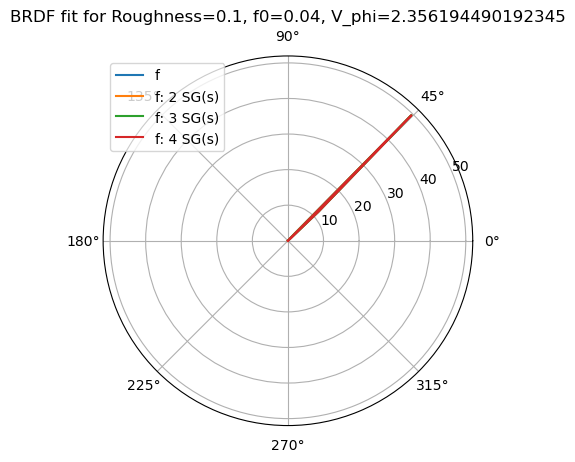

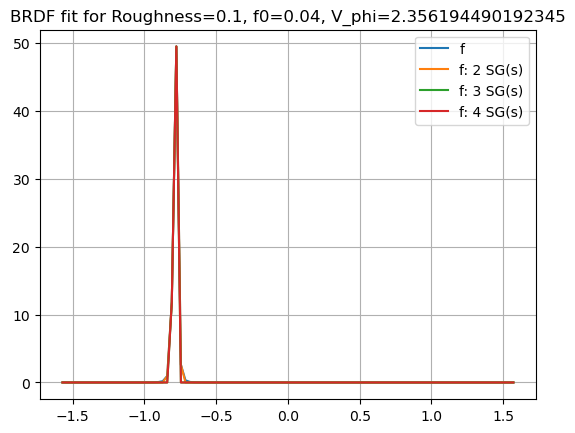

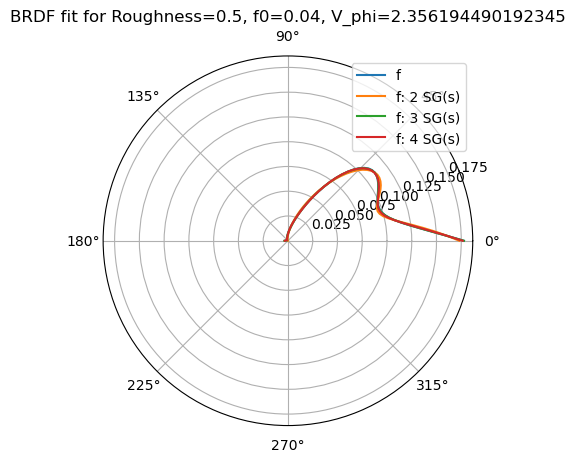

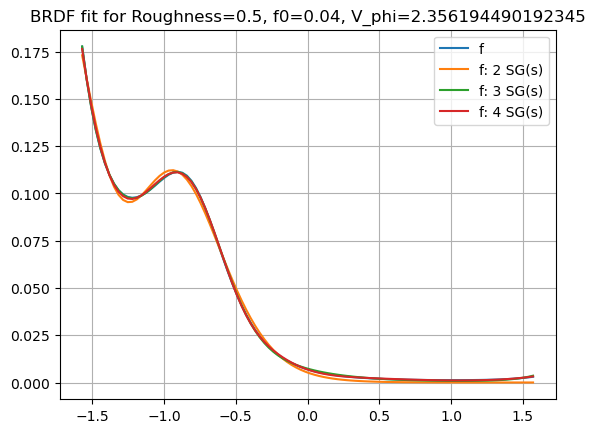

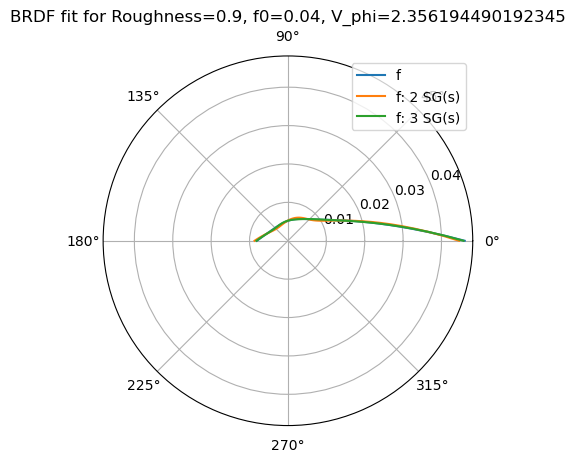

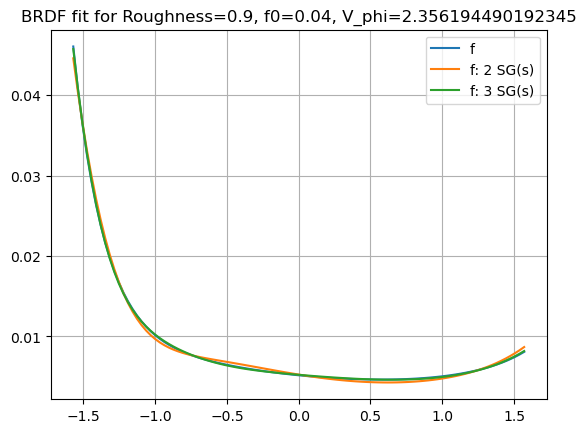

In [4]:
# Fit BRDF SG

for roughness in (0.1, 0.5, 0.9):
    f0 = 0.04
    alpha = roughness ** 2
    alpha2 = alpha ** 2

    N_phi = np.pi / 2
    V_phi = 3 * np.pi / 4
    R_phi = 2 * N_phi - V_phi
    N = polar_to_r3(N_phi)
    V = polar_to_r3(V_phi)

    phi = np.linspace(0, np.pi, num=100)
    L = polar_to_r3(phi)
    f = BRDF(f0, alpha, N, V, L)

    def eval_brdf_sg(phi, *args):
        args = np.array(args).reshape(-1, 3, 1)
        axis = args[:, 0]
        amp = args[:, 1]
        sh = args[:, 2]  
        return SG(polar_to_r3(axis, axis=1), amp, sh).eval(polar_to_r3(phi))

    brdf_sgs = []

    MIN_SG = 2
    MAX_SG = 4

    for k in range(MIN_SG, MAX_SG + 1):
        try:
            p0 = np.tile((R_phi, 1 / (np.pi * alpha2 * k), 2 / alpha2), k)
            brdf_sg, _ = sp.optimize.curve_fit(eval_brdf_sg, phi, f, p0=p0, maxfev=100_000)
            brdf_sgs.append(brdf_sg)
        except RuntimeError:
            break

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    plt.title(f"BRDF fit for Roughness={roughness}, f0={f0}, V_phi={V_phi}")
    ax.plot(phi, f, label="f")
    for k, brdf_sg in enumerate(brdf_sgs, start=MIN_SG):
        ax.plot(phi, eval_brdf_sg(phi, brdf_sg), label=f"f: {k} SG(s)")
    ax.grid(True)
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    plt.title(f"BRDF fit for Roughness={roughness}, f0={f0}, V_phi={V_phi}")
    ax.plot(phi - np.pi / 2, f, label="f")
    for k, brdf_sg in enumerate(brdf_sgs, start=MIN_SG):
        ax.plot(phi - np.pi / 2, eval_brdf_sg(phi, brdf_sg), label=f"f: {k} SG(s)")
    ax.grid(True)
    ax.legend()
    plt.show()

/tmp/ipykernel_117203/4108750627.py:20: RuntimeWarning: overflow encountered in exp
  r = self.amplitude * np.exp(self.sharpness * (dot(v, self.axis) - 1))


[[ 7.80957089e-01 -5.98619179e+00  2.34087168e+03]
 [ 7.86858866e-01 -3.23712221e-01  1.60663686e+02]]


/tmp/ipykernel_117203/4108750627.py:20: RuntimeWarning: overflow encountered in multiply
  r = self.amplitude * np.exp(self.sharpness * (dot(v, self.axis) - 1))


[[ 7.81094876e-01 -5.98578623e+00  2.38604539e+03]
 [ 7.86132764e-01 -3.91508140e-01  2.36047519e+02]
 [ 7.72369967e-01 -8.92295932e-02  4.45354956e+01]]
[[ 7.80957089e-01 -5.98619179e+00  2.34087165e+03]
 [ 7.86858866e-01 -3.23712164e-01  1.60663642e+02]
 [ 7.82982881e-01  4.66271973e-05  3.58254816e+03]
 [ 7.92570693e-01  1.25186211e-05  3.87183762e+03]]


/tmp/ipykernel_117203/3953823056.py:33: OptimizeWarning: Covariance of the parameters could not be estimated
  brdf_NoL_sg, _ = sp.optimize.curve_fit(eval_brdf_sg, phi, f_NoL, p0=p0, maxfev=100_000)


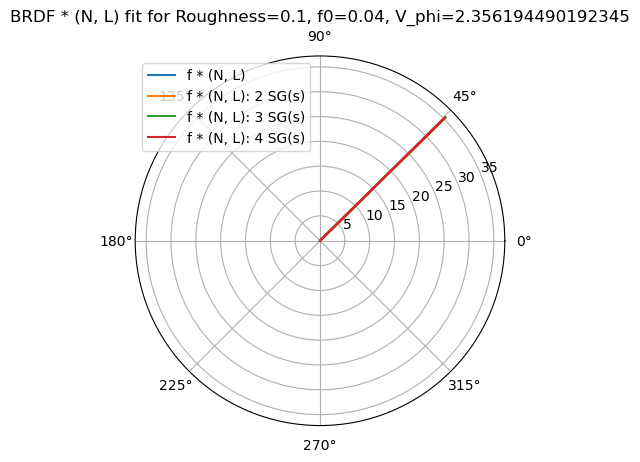

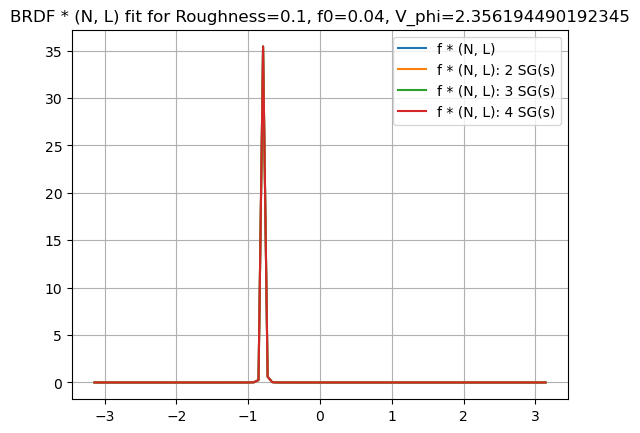

[[ 0.78536476  0.10803113 55.36518053]
 [ 0.74886394  0.24999926  8.11453932]]
[[ 0.23980437 -0.10911293 63.92041665]
 [ 1.23825467  0.091564    5.33353663]
 [ 0.74803373  0.26231089 13.34863711]]
[[2.46098069e-01 1.14564733e-01 5.72963136e+01]
 [1.97535756e+00 3.65220342e-02 4.04739246e+00]
 [1.20488158e+00 9.84329107e-02 8.98274514e+00]
 [7.43848264e-01 2.63704170e-01 1.41311891e+01]]


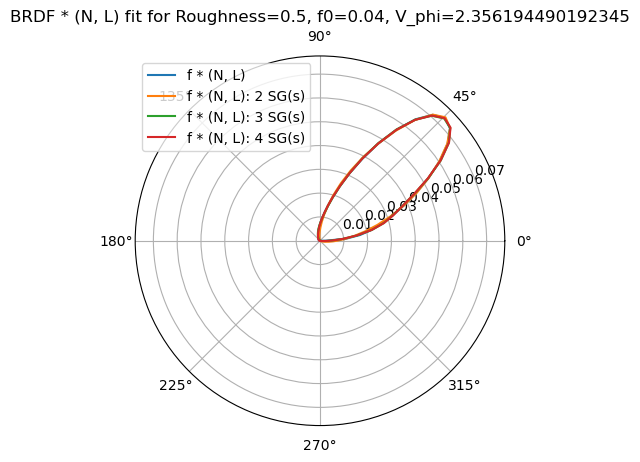

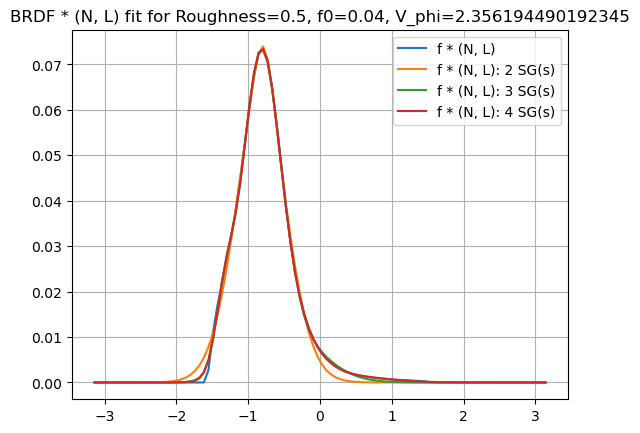

[[0.55031308 0.06587717 8.15193762]
 [1.64092071 0.07278533 2.21427686]]
[[ 0.95406049  0.07073661  5.52747538]
 [ 0.33094943  0.06044408 27.08054896]
 [ 1.99465697  0.06437279  3.22008232]]
[[6.04891758e-01 6.10591409e-02 1.41405572e+01]
 [1.31389972e+00 7.26639840e-02 4.66866416e+00]
 [2.43843919e-01 5.64094785e-02 5.56474408e+01]
 [2.30971977e+00 5.48989402e-02 5.49118681e+00]]


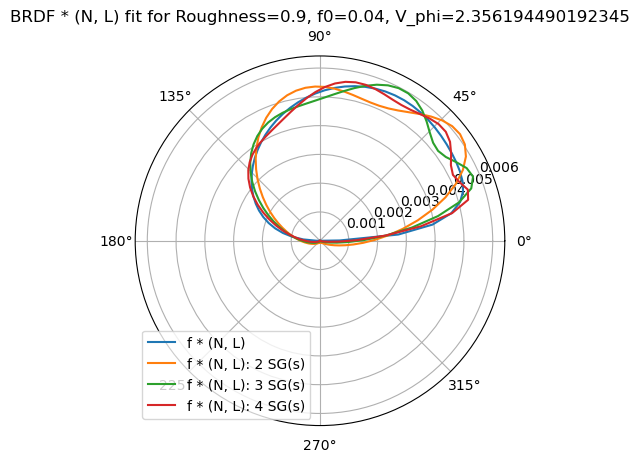

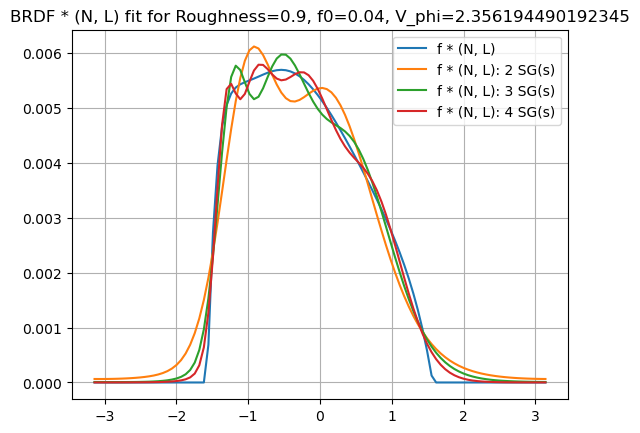

In [10]:
# Fit BRDF (N, L) SG

for roughness in (0.1, 0.5, 0.9):
    f0 = 0.04
    alpha = roughness ** 2
    alpha2 = alpha ** 2

    N_phi = np.pi / 2
    V_phi = 3 * np.pi / 4
    R_phi = 2 * N_phi - V_phi
    N = polar_to_r3(N_phi)
    V = polar_to_r3(V_phi)

    phi = np.linspace(-np.pi / 2, 3 * np.pi / 2, num=100)
    L = polar_to_r3(phi)
    f_NoL = BRDF(f0, alpha, N, V, L, mul_NoL=True)

    def eval_brdf_sg(phi, *args):
        args = np.array(args).reshape(-1, 3, 1)
        axis = args[:, 0]
        amp = args[:, 1]
        sh = args[:, 2]  
        return SG(polar_to_r3(axis, axis=1), amp ** 2, sh).eval(polar_to_r3(phi))

    brdf_NoL_sgs = []

    MIN_SG = 2
    MAX_SG = 4

    for k in range(MIN_SG, MAX_SG + 1):
        try:
            p0 = np.tile((R_phi, 1 / (np.pi * alpha2 * k), 2 / alpha2), k)
            brdf_NoL_sg, _ = sp.optimize.curve_fit(eval_brdf_sg, phi, f_NoL, p0=p0, maxfev=100_000)
            print(brdf_NoL_sg.reshape(-1, 3))
            brdf_NoL_sgs.append(brdf_NoL_sg)
        except RuntimeError:
            break

    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    plt.title(f"BRDF * (N, L) fit for Roughness={roughness}, f0={f0}, V_phi={V_phi}")
    ax.plot(phi, f_NoL, label="f * (N, L)")
    for k, brdf_NoL_sg in enumerate(brdf_NoL_sgs, start=MIN_SG):
        ax.plot(phi, eval_brdf_sg(phi, brdf_NoL_sg), label=f"f * (N, L): {k} SG(s)")
    ax.grid(True)
    ax.legend()
    plt.show()

    fig, ax = plt.subplots()
    plt.title(f"BRDF * (N, L) fit for Roughness={roughness}, f0={f0}, V_phi={V_phi}")
    ax.plot(phi - np.pi / 2, f_NoL, label="f * (N, L)")
    for k, brdf_NoL_sg in enumerate(brdf_NoL_sgs, start=MIN_SG):
        ax.plot(phi - np.pi / 2, eval_brdf_sg(phi, brdf_NoL_sg), label=f"f * (N, L): {k} SG(s)")
    ax.grid(True)
    ax.legend()
    plt.show()